In [2]:
import random
import requests
from bs4 import BeautifulSoup
import re
from googlesearch import search

def fetch_npr_article_fragments(article_url):
    print(f"Fetching article: {article_url}")

    try:
        response = requests.get(article_url)
        if response.status_code != 200:
            print(f"Failed to fetch article: {article_url}")
            return None

        soup = BeautifulSoup(response.content, "html.parser")

        content_divs = soup.find_all("p")
        content = " ".join(p.get_text(strip=True) for p in content_divs)

        # remove fragments looking like this: "Brendan Smialowski/AFP via Getty Images"
        content = re.sub(r"\b[A-Za-z]+(?: [A-Za-z]+)+/AFP via Getty Images\b", "", content)

        # we want fragments containing "Trump" or "Clinton"
        fragments = []
        sentences = re.split(r'(?<=[.!?])\s+', content)

        seen_fragments = set()
        for i, sentence in enumerate(sentences):
            if re.search(r'\b(Trump|Clinton)\b', sentence, re.IGNORECASE):
                num_sentences = random.choice([1, 2, 3])
                start_idx = max(0, i - (num_sentences - 1) // 2)
                end_idx = min(len(sentences), start_idx + num_sentences)
                fragment = " ".join(sentences[start_idx:end_idx])

                if fragment not in seen_fragments:
                    seen_fragments.add(fragment)
                    fragments.append(fragment)

        print(f"Relevant fragments: {fragments}")
        return fragments
    except Exception as e:
        print(f"Error fetching article content from {article_url}: {e}")
        return None

def get_npr_articles_via_google(query, max_articles=10):
    fragments = []
    search_query = f"{query} site:npr.org"
    article_links = []

    for link in search(search_query, num=max_articles):
        if len(article_links) >= max_articles:
            break
        article_links.append(link)
    article_links = list(dict.fromkeys(article_links)) # remove duplicates

    print(f"Found {len(article_links)} articles for query: {query}")

    for link in article_links:
        article_fragments = fetch_npr_article_fragments(link)
        if article_fragments:
            fragments.extend([(frag, "left") for frag in article_fragments])

    return fragments

queries = [
    "donald trump 2016 elections",
    "donald trump 2016 presidential rally",
    "hillary clinton 2016 elections",
    "hillary clinton presidential rally"
]

all_data = {}
for query in queries:
    print(f"Searching for: {query}")
    query_data = get_npr_articles_via_google(query, max_articles=100)
    all_data[query] = query_data

for query, fragments in all_data.items():
    print(f"\nResults for query '{query}':")
    for fragment, label in fragments:
        print(f"Fragment: {fragment}\nLabel: {label}\n---")


Streaming output truncated to the last 5000 lines.
Label: left
---
Fragment: "He wants us to fear the future and fear each other." She added: "Now we are clear-eyed about what our country is up against. But we are not afraid." Clinton closed by calling for unity beyond her party. She called for Americans to come together to find solutions to the big problems facing American society.
Label: left
---
Fragment: She called for Americans to come together to find solutions to the big problems facing American society. "We have to heal the divides in our country," Clinton said. "Not just on guns.
Label: left
---
Fragment: Clinton On Donald Trump: Clinton took a few swipes at the Republican presidential nominee Donald Trump.
Label: left
---
Fragment: This is one of the most cutting: "Donald Trump can't even handle the rough-and-tumble of a presidential campaign.
Label: left
---
Fragment: Chelsea Clinton Introduces Her Mom: Chelsea Clinton introduced her mother, saying she was onstage tonight as

In [21]:
for key in all_data.keys():
  print(len(all_data[key]))


3064
3433
3421
3373


In [22]:
import csv

def save_to_csv(data, filename="npr_articles.csv"):
    """
    Save fragments data to a CSV file.

    Parameters:
    - data: A dictionary where the key is the query and the value is a list of tuples (fragment, label).
    - filename: Name of the output CSV file.
    """
    with open(filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(["Fragment", "Label", "Year"])

        # Write data rows
        for query, fragments in data.items():
            for fragment, label in fragments:
                year = "2016"  # Assuming all data is from 2016 elections
                writer.writerow([fragment, label, year])

# Example usage with all_data from your scraping results:
save_to_csv(all_data)


In [27]:
from bs4 import BeautifulSoup
import requests
import re
import random
from googlesearch import search

def fetch_justthenews_article_fragments(article_url):
    print(f"Fetching article: {article_url}")
    try:
        response = requests.get(article_url)
        if response.status_code != 200:
            print(f"Failed to fetch article: {article_url}")
            return None

        soup = BeautifulSoup(response.content, "html.parser")

        # Extract main article content
        content_div = soup.find("div", {"class": "text-long"})  # Adjust based on Just the News' structure
        if not content_div:
            print(f"No content found at {article_url}")
            return None

        content = " ".join(p.get_text(strip=True) for p in content_div.find_all("p"))
        content = re.sub(r"\[.*?\]|(Photo|Image):.*", "", content)  # Remove captions
        print(f"Article content extracted: {content[:200]}...")  # Preview

        # Extract relevant fragments
        fragments = []
        sentences = re.split(r'(?<=[.!?])\s+', content)
        for i, sentence in enumerate(sentences):
            if re.search(r'\b(Trump|Clinton)\b', sentence, re.IGNORECASE):
                # Randomly choose 1-3 consecutive sentences
                num_sentences = random.choice([1, 2, 3])
                start_idx = max(0, i - (num_sentences - 1) // 2)
                end_idx = min(len(sentences), start_idx + num_sentences)
                fragment = " ".join(sentences[start_idx:end_idx])
                fragments.append(fragment)

        print(f"Relevant fragments: {fragments}")
        return fragments

    except Exception as e:
        print(f"Error fetching article content from {article_url}: {e}")
        return None

def get_justthenews_articles_via_google(query, max_articles=10):
    search_query = f"{query} site:justthenews.com/politics-policy"
    print(f"Searching Google for: {search_query}")

    article_links = []
    fragments = []

    for url in search(search_query, stop=max_articles):
        if len(article_links) >= max_articles:
            break
        article_links.append(url)

    for link in article_links:
        article_fragments = fetch_justthenews_article_fragments(link)
        if article_fragments:
            fragments.extend([(frag, "right") for frag in article_fragments])

    return fragments

# Example usage
queries = [
    "Donald Trump 2016 elections",
    "Donald Trump 2016 presidential rally",
    "Hillary Clinton 2016 elections",
    "Hillary Clinton presidential rally"
]

all_data = {}
for query in queries:
    print(f"Searching for: {query}")
    query_data = get_justthenews_articles_via_google(query, max_articles=30)
    all_data[query] = query_data

# Output collected data
for key, data in all_data.items():
    print(f"Data for {key}: {data}")


Searching for: Donald Trump 2016 elections
Searching Google for: Donald Trump 2016 elections site:justthenews.com/politics-policy
Fetching article: https://justthenews.com/politics-policy/elections/i-dont-get-it-polling-historian-who-nailed-trumps-2016-win-baffled-his
Article content extracted: An American University historian who became a polling celebrity bycorrectly predicting Donald Trump's presidential victory in 2016is flummoxed, and dispirited, by the president-elect's victory this ye...
Relevant fragments: ["An American University historian who became a polling celebrity bycorrectly predicting Donald Trump's presidential victory in 2016is flummoxed, and dispirited, by the president-elect's victory this year.", '"His lead is not diminished." Several seconds of silence followed before Sam noted "Michigan\'s gone red" and that Trump\'s Pennsylvania lead was growing.', '"It\'s very, very, very difficult," the father said. "I don\'t get it." Harris was supposed to win eight of the 1

In [ ]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 33.6 MB/s eta 0:00:00


In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import random
import time

def fetch_google_search_apnews_results(query_url, max_results=10, max_pages=4):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36"
    }

    article_urls = []
    page = 0
    while len(article_urls) < max_results and page < max_pages:
        # Add pagination to the query
        paginated_url = f"{query_url}&start={page * 10}"

        try:
            response = requests.get(paginated_url, headers=headers)
            if response.status_code != 200:
                print(f"Failed to fetch search results: {response.status_code}")
                return []

            soup = BeautifulSoup(response.text, "html.parser")
            links = soup.find_all("a")
            for link in links:
                href = link.get("href")
                if href and "apnews.com" in href:  # Filter AP News links
                    matched = re.search(r"https://apnews.com/[^\s&]*", href)
                    if matched:
                        article_url = matched.group(0)
                        if article_url not in article_urls:
                            article_urls.append(article_url)

            page += 1
            time.sleep(random.uniform(1, 2))  # To avoid getting blocked

        except Exception as e:
            print(f"Error fetching Google search results: {e}")
            break

    return article_urls[:max_results]  # Return the desired number of URLs

def fetch_apnews_article_fragments(article_url):
    print(f"Fetching AP News article: {article_url}")
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.75 Safari/537.36"
    }

    try:
        response = requests.get(article_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to fetch article: {article_url}")
            return []

        soup = BeautifulSoup(response.content, "html.parser")
        body = soup.find("div", {"class": "Page-storyBody"})

        if not body:
            print("Article body not found.")
            return []

        content = " ".join(p.get_text(strip=True) for p in body.find_all("p"))
        sentences = re.split(r'(?<=[.!?])\s+', content)

        fragments = []
        for i, sentence in enumerate(sentences):
            if re.search(r'\b(Trump|Clinton)\b', sentence, re.IGNORECASE):
                num_sentences = random.choice([2, 3, 4])
                start_idx = max(0, i - (num_sentences - 1) // 2)
                end_idx = min(len(sentences), start_idx + num_sentences)
                fragment = " ".join(sentences[start_idx:end_idx])
                fragments.append(fragment)

        return fragments

    except Exception as e:
        print(f"Error fetching article content from {article_url}: {e}")
        return []

def fetch_apnews_data(query_url, max_texts=100):
    article_urls = fetch_google_search_apnews_results(query_url, max_results=max_texts)
    all_fragments = []
    for url in article_urls:
        fragments = fetch_apnews_article_fragments(url)
        all_fragments.extend((fragment, "center") for fragment in fragments)
        if len(all_fragments) >= max_texts:
            break
        time.sleep(random.uniform(1, 2))
    return all_fragments

def get_2016_data_apnews():
    data = []  # (text, leaning), leaning="center"
    urls = [
        "https://www.google.com/search?q=site%3Aapnews.com+donald+trump+2016+elections+after%3A2014-01-01+before%3A2017-06-01",
        "https://www.google.com/search?q=site%3Aapnews.com+hillary+clinton+2016+elections+after%3A2014-01-01+before%3A2017-06-01"
    ]
    for url in urls:
        data += fetch_apnews_data(url, max_texts=400)
    return data


In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import random
import time

def fetch_google_search_newsmax_results(query_url, max_results=10):
    headers = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    article_urls = []
    page = 0
    while len(article_urls) < max_results and page < 15:
        print(f"will get some google articles... size of article_urls: {len(article_urls)}")
        paginated_url = f"{query_url}&start={page * 10 + 3}"

        try:
            response = requests.get(paginated_url, headers=headers)
            if response.status_code != 200:
                print(f"Failed to fetch Google results: {response.status_code}")
                return []

            print(f"got the google page. article_urls size: {len(article_urls)}")

            soup = BeautifulSoup(response.text, "html.parser")
            links = soup.find_all("a")
            for link in links:
                href = link.get("href")
                if href and "newsmax.com" in href:
                    matched = re.search(r"https://www\.newsmax\.com/[^\s&]*", href)
                    if matched:
                        article_url = matched.group(0)
                        if article_url not in article_urls:
                            article_urls.append(article_url)

            page += 1
            time.sleep(random.uniform(1, 2))

        except Exception as e:
            print(f"Error fetching Google search results: {e}")
            break

    return article_urls[:max_results]

def fetch_newsmax_article_fragments(article_url):
    print(f"Fetching Newsmax article: {article_url}")

    try:
        response = requests.get(article_url)
        if response.status_code != 200:
            print(f"Failed to fetch article: {article_url}")
            return []
        print(f"response content: {response.content}")

        soup = BeautifulSoup(response.content, "html.parser")
        body = soup.find("div", {"id": "mainArticleDiv"})

        content = " ".join(p.get_text(strip=True) for p in body.find_all("p"))
        sentences = re.split(r'(?<=[.!?])\s+', content)

        fragments = []
        for i, sentence in enumerate(sentences):
            if re.search(r'\b(Trump|Clinton)\b', sentence, re.IGNORECASE): # sentences mentioning either candidate
                num_sentences = random.choice([2, 3, 4])
                start_idx = max(0, i - (num_sentences - 1) // 2)
                end_idx = min(len(sentences), start_idx + num_sentences)
                fragment = " ".join(sentences[start_idx:end_idx])
                fragments.append(fragment)

        return fragments

    except Exception as e:
        print(f"Error fetching article content from {article_url}: {e}")
        return []

def fetch_newsmax_data(query_url, max_texts=100):
    article_urls = fetch_google_search_newsmax_results(query_url, max_results=max_texts)
    all_fragments = []
    for url in article_urls:
        fragments = fetch_newsmax_article_fragments(url)
        all_fragments.extend((fragment, "right") for fragment in fragments)
        if len(all_fragments) >= max_texts:
            break
        time.sleep(random.uniform(1, 2))
    return all_fragments

def get_2016_data_newsmax():
    data = []  # (text, leaning), leaning="right"


    # TODO unless we get 429 (too many requests), use the fetch_newsmax_data function
    # urls = [
    #     "https://www.google.com/search?q=site%3Anewsmax.com+donald+trump+2016+elections+after%3A2014-01-01+before%3A2017-06-01",
    #     "https://www.google.com/search?q=site%3Anewsmax.com+hillary+clinton+2016+elections+after%3A2014-01-01+before%3A2017-06-01"
    # ]
    # for url in urls:
    #     data += fetch_newsmax_data(url, max_texts=400 // len(urls) + 1)

    handpicked_article_urls = [
        "https://www.newsmax.com/headline/trump-clinton-debate-preparation/2016/09/22/id/749606/",
        "https://www.newsmax.com/thewire/year-review-2016/2016/12/30/id/766183/",
        "https://www.newsmax.com/headline/trump-won-debate-snap/2016/09/27/id/750421/",
        "https://www.newsmax.com/bestlists/30-under-30-influential-young-republicans/2017/01/11/id/767932/",
        "https://www.newsmax.com/politics/nate-silver-election-tight-presidential/2016/09/01/id/746282/",
        "https://www.newsmax.com/newsfront/us-airstrike-military-pace/2017/04/04/id/782534/",
        "https://www.newsmax.com/newsfront/carson-trump-response-mud/2015/10/25/id/698929/",
        "https://www.newsmax.com/bestlists/african-american-republicans-influential-newsmax/2017/02/22/id/774949/",
        "https://www.newsmax.com/bestlists/latino-republicans-newsmax-list/2017/03/28/id/781113/",
        "https://www.newsmax.com/thewire/donald-trump-rooster-statue-china/2016/12/28/id/765933/",
        "https://www.newsmax.com/headline/jessica-leeds-cnn-groping-accusations/2016/10/13/id/753314/",
        "https://www.newsmax.com/thewire/syrian-refugees-presidential-candidates/2015/11/17/id/702489/",
        "https://www.newsmax.com/politics/cnn-trump-supporter-scottie-nell-hughes/2016/07/06/id/737314/",
        "https://www.newsmax.com/politics/john-noonan-trump-nuclear-deterrance/2016/08/03/id/742047/",
        "https://www.newsmax.com/thewire/harriet-tubman-twenty-dollar-bill-andrew-jackson/2016/04/21/id/725097/",
        "https://www.newsmax.com/thewire/chris-matthews-melania-trump-hot-mic-tingle/2016/05/06/id/727514/",
        "https://www.newsmax.com/newsmax-tv/webb-hubbell-chelsea-clinton-bernie-sanders/2016/01/15/id/709680/",
        "https://www.newsmax.com/Finance/streettalk/deficit-talks-economy-lawmakers/2014/05/14/id/571325/",
        "https://www.newsmax.com/newsfront/hillary-clinton-trump-2024-mlk/2022/01/17/id/1052730/",
        "https://www.newsmax.com/TheWire/reasons-hillary-lost-president/2016/11/10/id/758175/",
        "https://www.newsmax.com/DanPerkins/hillary-clinton-russia-uranium/2017/10/31/id/823135/",
        "https://www.newsmax.com/Politics/counties-rich-gdp-Hillary-Clinton/2016/11/22/id/760259/",
        "https://www.newsmax.com/Newsfront/john-bolton-chris-stevens-email-hillary/2016/03/01/id/716847/",
        "https://www.newsmax.com/Newsmax-Tv/webb-hubbell-chelsea-clinton-bernie-sanders/2016/01/15/id/709680/",
        "https://www.newsmax.com/Headline/lynch-remove-clinton-email/2016/07/01/id/736610/",
        "https://www.newsmax.com/Headline/Psychics-divided-Election/2016/11/05/id/757228/",
        "https://www.newsmax.com/Headline/Sources-Question-Hillary-Clinton-Health/2016/01/07/id/708520/",
        "https://www.newsmax.com/US/Hillary-DSouza-documentary-movie/2014/06/13/id/576956/",
        "https://www.newsmax.com/Newsmax-Tv/ed-klein-hillary-clinton-crying-election/2016/11/09/id/758084/"
    ]
    for url in handpicked_article_urls:
        fragments = fetch_newsmax_article_fragments(url)
        data.extend((fragment, "right") for fragment in fragments)

    return data


In [ ]:
def get_data_for_year(year):
  if year == 2016:
    data = []
    data += get_2016_data_jacobin()
    data += get_2016_data_apnews()
    # data += get_2016_data_newsmax()

    return data

In [ ]:
data_2016 = get_data_for_year(2016)

print(f"data_2016[...]:{data_2016[random.randint(0, 20)]}")

fetching article: https://jacobin.com/2016/10/trump-gop-republicans-tea-party-populism-fascism
article content: For over eighty years, the reformist left in the United States has sought to transform one of the capitalist parties into a “people’s” party. Both the Communist Party’s popular front strategy and the social-democratic strategy of “realignment” (formulated by the brilliant ex-Marxist Max Shachtman) sought to transform the Democratic Party. The Democrats, through the 1950s, were a coalition of urban real estate developers, Jewish and Catholic capitalists, and southern planters who enjoyed the voting support of northern industrial workers, black and white, middle-class liberals, and most southern whites.The reformists’ goal was to drive out the conservative, pro-capitalist elements — especially the Dixiecrats — leaving the labor officialdom and middle-class liberals to dominate a “labor-liberal” Party. AsPaul Heidemanrecently pointed out in a recent essay inJacobin, there was a 

NameError: name 'data_2016' is not defined

In [ ]:
# data_2020_jacobin = get_data_for_year(2020)

# print(f"data_2020_2[...]:{data_2020_jacobin[random.randint(0, 20)]}")

In [ ]:
# print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")
# print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")
# print(f"data_2020[...]:{data_2020[random.randint(0, 20)]}")


In [ ]:
# data_2020_newsmax = get_data_for_year(2020)

# print(f"data_2020_2[...]:{data_2020_newsmax[random.randint(0, 20)]}")

In [ ]:
data_newsmax_2016 = get_2016_data_newsmax()

Fetching Newsmax article: https://www.newsmax.com/headline/trump-clinton-debate-preparation/2016/09/22/id/749606/
response content: b'<!DOCTYPE html>\r\n<html   lang="en">\r\n<head id="head">\r\n<title>\r\n\tTrump Weighs Aggressive Tactics Against Clinton in First Debate | Newsmax.com\r\n</title><meta name="epoch" content="1474548531" />\r\n<meta name="pubdate" property="pubdate" content="2016-09-22T12:48:51-04:00" />\r\n<meta property="article:section" content="headline" />\r\n<meta property="article:published_time" content="2016-09-22T12:48:51-04:00" />\r\n<meta name="og:description" property="og:description" content="Hillary Clinton and Donald Trump have been locked in a fierce election battle for months, but tens of millions of Americans will compare their presidential bona fides side-by-side anew on Monday." />\r\n<meta name="og:page_id" property="og:page_id" content="85452072376" />\r\n<meta name="fb:app_id" property="fb:app_id" content="323020797885219" />\r\n<meta name="fb:admi

In [ ]:
# data_2016 += data_newsmax_2016

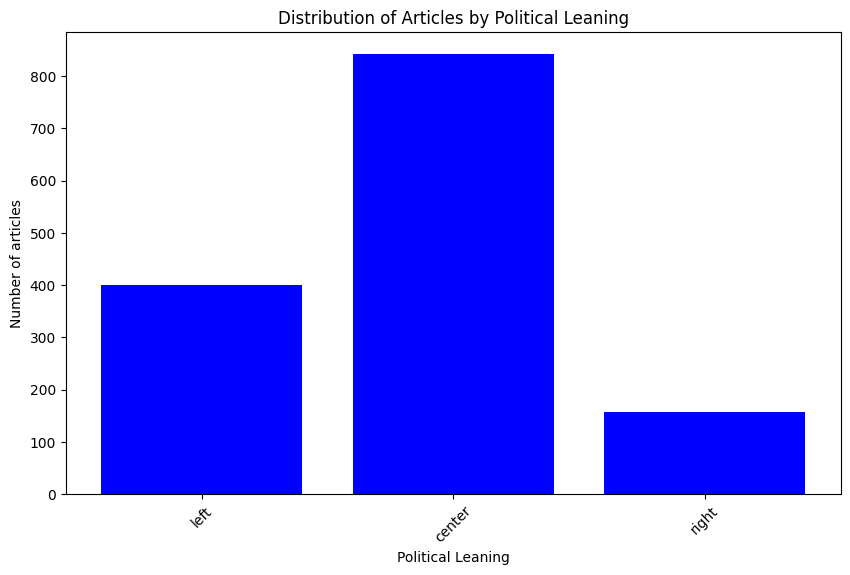

Total articles: 1399
Distribution by political leaning:
left: 400
center: 842
right: 157


In [ ]:
# data analysis

from collections import Counter
import matplotlib.pyplot as plt

def display_statistics(data):
    leanings = [fragment[1] for fragment in data] # data: [(text, leaning), ...]
    counts = Counter(leanings)

    labels = counts.keys()
    values = counts.values()

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color='blue')
    plt.xlabel('Political Leaning')
    plt.ylabel('Number of articles')
    plt.title('Distribution of Articles by Political Leaning')
    plt.xticks(rotation=45)
    plt.show()

    print("Total articles:", len(data))
    print("Distribution by political leaning:")
    for leaning, count in counts.items():
        print(f"{leaning}: {count}")

display_statistics(data_2016)

In [ ]:
import csv

def save_data(data, filename="2016_election_data.csv"):
    data_with_year = [(text, leaning, 2016) for text, leaning in data]

    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Text", "Leaning", "Year"])
        writer.writerows(data_with_year)

    print(f"Saved to {filename}")

save_data(data_2016)

Saved to 2016_election_data.csv
